In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import r2_score

In [6]:
# 1. 데이터 준비 및 타겟 생성
df = pd.read_csv("C:/Users/user/fin_project/db/news(23-25)_summarized_external_clean.csv")  # 데이터셋 불러오기

In [7]:
# test용
# df = df.sample(1000, random_state=42).reset_index(drop=True)

In [8]:
# 다중 시점 종가를 타겟으로 설정
target_cols = ['D_plus_1_date_close', 'D_plus_2_date_close', 'D_plus_3_date_close', 'D_plus_7_date_close', 'D_plus_14_date_close']
df['target'] = df[target_cols].values.tolist()  # 각 row에 plus 종가가 리스트로 저장됨


In [9]:
external_cols = [
    'fx', 'bond10y', 'base_rate',
    'D_minus_14_date_close', 'D_minus_14_date_volume', 'D_minus_14_date_foreign',
    'D_minus_14_date_institution', 'D_minus_14_date_individual',
    'D_minus_7_date_close', 'D_minus_7_date_volume', 'D_minus_7_date_foreign',
    'D_minus_7_date_institution', 'D_minus_7_date_individual',
    'D_minus_3_date_close', 'D_minus_3_date_volume', 'D_minus_3_date_foreign',
    'D_minus_3_date_institution', 'D_minus_3_date_individual',
    'D_minus_2_date_close', 'D_minus_2_date_volume', 'D_minus_2_date_foreign',
    'D_minus_2_date_institution', 'D_minus_2_date_individual',
    'D_minus_1_date_close', 'D_minus_1_date_volume', 'D_minus_1_date_foreign',
    'D_minus_1_date_institution', 'D_minus_1_date_individual'
]

In [10]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1.1 훈련/검증 분할(데이터 누수 방지)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 1.2 타겟/외부 변수 스케일러 (훈련 데이터만으로 fit)
target_scaler = StandardScaler() # 타겟(5개 종가) 스케일링
external_scaler = StandardScaler() # 외부 변수(27개) 스케일링

# 검증 세트는 스케일러 학습에 전혀 사용 X

train_targets = np.array(train_df['target'].tolist())
train_externals = train_df[external_cols].values
target_scaler.fit(train_targets)
external_scaler.fit(train_externals)


StandardScaler()

In [11]:
# 2. 데이터셋 클래스
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, external_cols, target_scaler, external_scaler, max_len=512):
        self.texts = df['article_preprocessed'].tolist()
        self.external = torch.tensor(
            external_scaler.transform(df[external_cols].values), dtype=torch.float32 # 훈련 스케일러 적용
        )
        self.targets = torch.tensor(
            target_scaler.transform(np.array(df['target'].tolist())), dtype=torch.float32
        )
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # 불필요한 배치 차원 제거 (예: [1,512] → [512])
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'external': self.external[idx]
        }, self.targets[idx]

In [12]:
# 3. 모델 정의 (다중 출력)
class NewsImportancePredictor(nn.Module):
    def __init__(self, embedding_model_name='snunlp/KR-SBERT-V40K-klueNLI-augSTS',
                 external_feature_dim=27, ae_hidden=256, ae_bottleneck=64,
                 fcl_hidden=512, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(embedding_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
        self.encoder = nn.Sequential( # 768 → 256 → 64
            nn.Linear(768, ae_hidden),
            nn.GELU(),
            nn.Linear(ae_hidden, ae_bottleneck)
        )
        self.decoder = nn.Sequential(  # 64 → 256 → 768
            nn.Linear(ae_bottleneck, ae_hidden),
            nn.GELU(),
            nn.Linear(ae_hidden, 768)
        )
        self.predictor = nn.Sequential(
            nn.Linear(ae_bottleneck + external_feature_dim, fcl_hidden), # 잠재벡터 + 외부변수, fcl_hidden: 512
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fcl_hidden, fcl_hidden//2),
            nn.GELU(),
            nn.Linear(fcl_hidden//2, 5)  # 5개 시점 주가 예측
        )

    def forward(self, input_ids, attention_mask, external):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:,0,:]
        latent = self.encoder(embeddings)
        reconstructed = self.decoder(latent)
        combined = torch.cat([latent, external], dim=1)
        pred = self.predictor(combined)
        return pred, reconstructed

In [13]:
# 4. 오토인코더 사전 학습
# 버트 임베딩 그대로 복원하도록 ae만 따로 학습
# 버트는 프리징

def train_autoencoder(model, dataloader, epochs=10, device='cuda'):
    ae_optimizer = torch.optim.AdamW(
        list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=1e-4)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            with torch.no_grad(): # 버트 프리징
                bert_outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
                bert_embeds = bert_outputs.last_hidden_state[:,0,:]
            latent = model.encoder(bert_embeds)
            reconstructed = model.decoder(latent)
            loss = criterion(reconstructed, bert_embeds)
            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()
            total_loss += loss.item()
        print(f"[AE] Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f}")

In [14]:
def evaluate_metrics(preds, targets):
    mae = nn.L1Loss()(preds, targets).item()
    rmse = torch.sqrt(nn.MSELoss()(preds, targets)).item()
    return mae, rmse

def evaluate_r2(preds, targets):
    r2 = r2_score(targets, preds)
    return r2

def plot_loss(train_losses, val_losses):
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()

def train_predictor(model, train_loader, val_loader, target_scaler, device='cuda', epochs=50, patience=5):
    optimizer = torch.optim.AdamW(model.predictor.parameters(), lr=1e-5)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch[0]['input_ids'].to(device)
            attention_mask = batch[0]['attention_mask'].to(device)
            external = batch[0]['external'].to(device)
            targets = batch[1].to(device)

            preds, _ = model(input_ids, attention_mask, external)
            loss = criterion(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[Main] Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f}")

        model.eval()
        with torch.no_grad():
            val_loss = 0
            all_preds = []
            all_targets = []

            for batch in val_loader:
                input_ids = batch[0]['input_ids'].to(device)
                attention_mask = batch[0]['attention_mask'].to(device)
                external = batch[0]['external'].to(device)
                targets = batch[1].to(device)

                preds, _ = model(input_ids, attention_mask, external)
                loss = criterion(preds, targets)
                val_loss += loss.item()

                all_preds.append(preds.cpu())
                all_targets.append(targets.cpu())

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            all_preds = torch.cat(all_preds, dim=0).numpy()
            all_targets = torch.cat(all_targets, dim=0).numpy()

            # 스케일 역변환
            all_preds_inverse = target_scaler.inverse_transform(all_preds)
            all_targets_inverse = target_scaler.inverse_transform(all_targets)

            print("all_preds shape:", all_preds.shape)
            print("all_targets shape:", all_targets.shape)
            print("all_preds range: min =", all_preds.min(), ", max =", all_preds.max())
            print("all_targets range: min =", all_targets.min(), ", max =", all_targets.max())

            mae, rmse = evaluate_metrics(
                torch.tensor(all_preds_inverse, dtype=torch.float32),
                torch.tensor(all_targets_inverse, dtype=torch.float32)
            )
            r2 = evaluate_r2(all_preds_inverse, all_targets_inverse)

            print(f"        Validation Loss: {avg_val_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            print(f"        EarlyStopping patience {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"        EarlyStopping triggered at epoch {epoch+1}!")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break

    plot_loss(train_losses, val_losses)

[AE] Epoch 1/5 | Loss: 0.4478
[AE] Epoch 2/5 | Loss: 0.3279
[AE] Epoch 3/5 | Loss: 0.2922
[AE] Epoch 4/5 | Loss: 0.2714
[AE] Epoch 5/5 | Loss: 0.2575
[Main] Epoch 1/10 | Train Loss: 0.7927
all_preds shape: (2692, 5)
all_targets shape: (2692, 5)
all_preds range: min = -0.85235107 , max = 2.3633056
all_targets range: min = -0.68108916 , max = 11.708527
        Validation Loss: 0.5334 | MAE: 68993.1875 | RMSE: 119299.5469 | R2: 0.4979
[Main] Epoch 2/10 | Train Loss: 0.2819
all_preds shape: (2692, 5)
all_targets shape: (2692, 5)
all_preds range: min = -1.1907021 , max = 5.1132216
all_targets range: min = -0.68108916 , max = 11.708527
        Validation Loss: 0.1034 | MAE: 29372.0703 | RMSE: 52524.2148 | R2: 0.9029
[Main] Epoch 3/10 | Train Loss: 0.1047
all_preds shape: (2692, 5)
all_targets shape: (2692, 5)
all_preds range: min = -1.141845 , max = 5.8558984
all_targets range: min = -0.68108916 , max = 11.708527
        Validation Loss: 0.0555 | MAE: 21219.7461 | RMSE: 38543.9609 | R2: 0.94

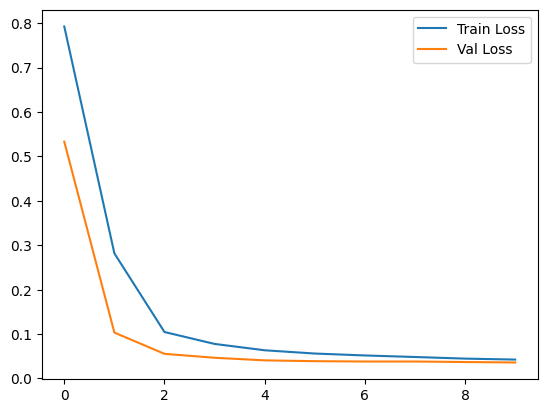

In [15]:
# 6. 전체 파이프라인 실행
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = NewsImportancePredictor(external_feature_dim=len(external_cols)).to(device)
    # 훈련 / 검증 분리
    dataset_train = NewsDataset(
        train_df,
        model.tokenizer,
        external_cols,
        target_scaler,  # 훈련 데이터로 피팅된 스케일러
        external_scaler # 훈련 데이터로 피팅된 스케일러
        )
    dataset_val = NewsDataset(
        val_df,
        model.tokenizer,
        external_cols,
        target_scaler, # 동일 스케일러 사용!
        external_scaler # 동일 스케일러 사용!
        )

    # DataLoader
    ae_train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
    train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=32)

    # 1) 오토인코더 사전학습
    train_autoencoder(model, ae_train_loader, epochs=5, device=device)

    # 2) 주요 예측기 학습 (얼리스타핑)
    train_predictor(model, train_loader, val_loader, target_scaler, device=device, epochs=10, patience=3)

In [16]:
import os
import pickle
import torch

save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

# 이미 학습된 model, target_scaler, external_scaler가 메모리에 있다면 바로 저장 가능
torch.save(model, os.path.join(save_dir, "full_model.pth"))
torch.save(model.state_dict(), os.path.join(save_dir, "model_weights.pth"))

with open(os.path.join(save_dir, "target_scaler.pkl"), "wb") as f:
    pickle.dump(target_scaler, f)
with open(os.path.join(save_dir, "external_scaler.pkl"), "wb") as f:
    pickle.dump(external_scaler, f)


saved_models/  
├── full_model.pth        # 전체 모델 구조+가중치  
├── model_weights.pth     # 가중치만  
├── target_scaler.pkl     # 타겟 스케일러  
└── external_scaler.pkl   # 외부 변수 스케일러  


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 88 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   news_id                      13459 non-null  object 
 1   wdate                        13459 non-null  object 
 2   title                        13459 non-null  object 
 3   article                      13459 non-null  object 
 4   press                        13459 non-null  object 
 5   url                          13459 non-null  object 
 6   image                        13459 non-null  object 
 7   article_preprocessed         13459 non-null  object 
 8   summary                      13459 non-null  object 
 9   stock_list                   13459 non-null  object 
 10  industry_list                13459 non-null  object 
 11  summary_embedding            13459 non-null  object 
 12  stock_name                   13459 non-null  object 
 13  ticker          

In [20]:
df.to_csv("dum.csv")

In [21]:
# 최대 열 개수 설정 (None으로 하면 모든 열 보임)
pd.set_option('display.max_columns', None)

In [22]:
df

,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding,stock_name,ticker,D_day_date,D_minus_14_date,D_minus_7_date,D_minus_3_date,D_minus_2_date,D_minus_1_date,D_plus_1_date,D_plus_2_date,D_plus_3_date,D_plus_7_date,D_plus_14_date,news_date,D_minus_14_date_close,D_minus_14_date_volume,D_minus_14_date_foreign,D_minus_14_date_institution,D_minus_14_date_individual,D_minus_7_date_close,D_minus_7_date_volume,D_minus_7_date_foreign,D_minus_7_date_institution,D_minus_7_date_individual,D_minus_3_date_close,D_minus_3_date_volume,D_minus_3_date_foreign,D_minus_3_date_institution,D_minus_3_date_individual,D_minus_2_date_close,D_minus_2_date_volume,D_minus_2_date_foreign,D_minus_2_date_institution,D_minus_2_date_individual,D_minus_1_date_close,D_minus_1_date_volume,D_minus_1_date_foreign,D_minus_1_date_institution,D_minus_1_date_individual,D_day_date_close,D_day_date_volume,D_day_date_foreign,D_day_date_institution,D_day_date_individual,D_plus_1_date_close,D_plus_1_date_volume,D_plus_1_date_foreign,D_plus_1_date_institution,D_plus_1_date_individual,D_plus_2_date_close,D_plus_2_date_volume,D_plus_2_date_foreign,D_plus_2_date_institution,D_plus_2_date_individual,D_plus_3_date_close,D_plus_3_date_volume,D_plus_3_date_foreign,D_plus_3_date_institution,D_plus_3_date_individual,D_plus_7_date_close,D_plus_7_date_volume,D_plus_7_date_foreign,D_plus_7_date_institution,D_plus_7_date_individual,D_plus_14_date_close,D_plus_14_date_volume,D_plus_14_date_foreign,D_plus_14_date_institution,D_plus_14_date_individual,D_day_date_open,D-day_change_open,D-day_change,fx,bond10y,base_rate,target
0,20240101_0049,2024-01-01 06:03:00,태영건설 파장 속 PF-ABCP '거래 부진'…차환 우려 고개,"PF 구조조정에 건설업 기피심리↑…""익숙한 악재라 파장 적을 것"" 관측도\n워크아웃...",연합뉴스,https://n.news.naver.com/mnews/article/001/001...,https://imgnews.pstatic.net/image/001/2024/01/...,시공능력 순위 16위의 중견기업인 태영건설이 워크아웃을 신청하면서 부동산 PF 부실...,시공능력 순위 16위의 중견기업인 태영건설이 워크아웃을 신청하면서 부동산 PF 부실...,['태영건설'],['토목 건설업'],"[-0.14925730228424072, -0.5277271866798401, -0...",태영건설,9410.0,2024-01-02,2023-12-08,2023-12-19,2023-12-26,2023-12-27,2023-12-28,2024-01-03,2024-01-04,2024-01-05,2024-01-11,2024-01-22,2024-01-01,7233.0,166163.0,6.647398e+07,-1.537188e+07,-5.122016e+07,5788.0,344256.0,7.729805e+07,-3.500570e+06,-8.288448e+07,6083.0,556200.0,-1.315100e+06,2.901710e+07,-1.269635e+07,4893.0,1934186.0,-4.761420e+08,-3.704570e+08,7.786477e+08,4710.0,17131642.0,1.338444e+08,-1.804754e+08,1.182515e+08,5330.0,7156884.0,4.766756e+08,-1.505398e+07,-4.276971e+08,6602.0,14277692.0,2.224048e+09,-1.686757e+07,-2.098160e+09,6246.0,20526299.0,-3.532130e+09,4.050960e+07,3.491563e+09,6287.0,5621781.0,1.740618e+07,2.416950e+05,-3.951262e+07,7660.0,16459819.0,5.971066e+09,-2.546250e+05,-5.888326e+09,4872.0,632513.0,2.411097e+08,2.445000e+03,-2.413366e+08,4638.0,14.920224,13.163482,1289.4,3.154,3.50,"[6602.0, 6246.0, 6287.0, 7660.0, 4872.0]"
1,20240101_0001,2024-01-01 18:30:00,통합 셀트리온 12일 상장… 잭팟 터지나,합병 전 외국인·기관 동반 매수\n올해 영업익 1조5130억 전망\n최근 증시 상승...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2024/01/...,새해 출범하는 '통합 셀트리온'에 대한 기대감이 커지는 것으로 풀이된다. 외국인과 ...,외국인과 기관이 지난해 12월 삼성전자 주식을 1조4267억원어치 사들이며 전체 주...,['삼성전자'],['통신 및 방송 장비 제조업'],"[0.211165189743042, -1.0113810300827026, -0.13...",삼성전자,5930.0,2024-01-02,2023-12-08,2023-12-19,2023-12-26,2023-12-27,2023-12-28,2024-01-03,2024-01-04,2024-01-05,2024-01-11,2024-01-22,2024-01-01,72600.0,10859463.0,1.013434e+11,1.594023e+11,-2.615169e+11,73400.0,8907632.0,-3.808070e+10,8.831266e+10,-4.647848e+10,76600.0,13164909.0,3.718129e+10,3.030082e+11,-3.324287e+11,78000.0,20651042.0,3.203872e+11,-8.556869e+10,-2.286355e+11,78500.0,17797536.0,8.593716e+10,2.217516e+11,-2.453861e+11,79600.0,17142847.0,1.829740e+11,4.509347e+10,-2.259543e+11,77000.0,21753644.0,3.012775e+10,-3.028125e+11,2.788679e+11,76600.0,15324439.0,4.884858e+10,-1.909815e+11,1.414521e+11,76600.0,11304316.0,-4.129268e+10,-8.054751e+10,1.186206e+11,73200.0

In [24]:
# 1. 스케일러 누수 점검
print("훈련 데이터 shape:", train_df.shape)
print("검증 데이터 shape:", val_df.shape)

# 2. 데이터 중복 확인
# 'target' 컬럼 제외 후 중복 확인
common_cols = [col for col in train_df.columns if col != 'target']
print("train/val 중복 row 수:", pd.merge(train_df[common_cols], val_df[common_cols]).shape[0])


# 3. 시계열 분할 체크
# 'date' 컬럼명 확인 (실제 데이터에 따라 수정 필요)
date_col = 'date'  # 실제 날짜 컬럼명으로 변경
print("train 마지막 날짜:", train_df[date_col].max())
print("val 첫 날짜:", val_df[date_col].min())

# 4. 입력 변수에 미래 정보 포함 여부
# external_cols에서 'plus'가 포함된 컬럼 검색
print([col for col in external_cols if 'plus' in col])



훈련 데이터 shape: (10767, 88)
검증 데이터 shape: (2692, 88)
train/val 중복 row 수: 0


KeyError: 'date'